# Periodic transit search

In this notebook, we use `nuance` to search for a periodic transit.

In [1]:
# in order to run on all CPUs
import os
import jax

jax.config.update("jax_enable_x64", True)
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

## Generating the data

Let's generate some data first

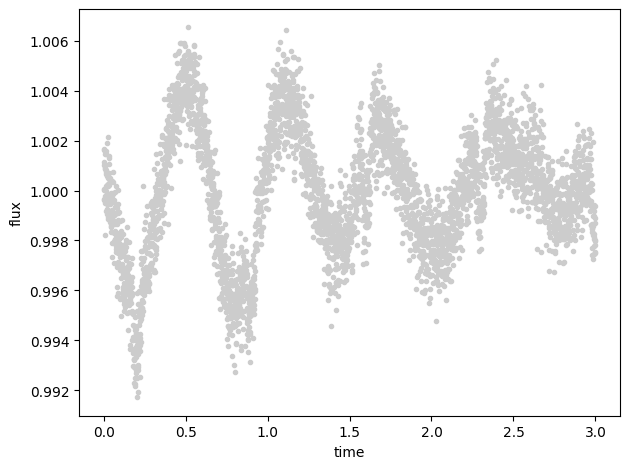

In [2]:
import numpy as np
from nuance import core
import matplotlib.pyplot as plt
from tinygp import kernels, GaussianProcess

depth = 2.3e-3
error = 1e-3
time = np.linspace(0, 3.0, 4000)
transit_prams = {"epoch": 0.2, "duration": 0.05, "period": 0.7}
transit_model = depth * core.transit(time, **transit_prams)
kernel = kernels.quasisep.SHO(10.0, 10.0, 0.002)
gp = GaussianProcess(kernel, time, diag=error**2)
flux = transit_model + gp.sample(jax.random.PRNGKey(0)) + 1.0


ax = plt.subplot(111, xlabel="time", ylabel="flux")
plt.plot(time, flux, ".", c="0.8")
plt.tight_layout()

## Linear search

We now run the [`linear_search`](nuance.linear_search)

In [3]:
from nuance.linear_search import linear_search

epochs = time.copy()
durations = np.linspace(0.01, 0.2, 15)

ls = linear_search(time, flux, gp=gp)(epochs, durations)

100%|██████████| 4008/4008 [00:01<00:00, 2438.61it/s]


```{note}
Notice how we reused the same Gaussian Process used to generate the data. In practice, a kernel need to be chosen and its hyper-parameters optimized. See the [GP optimization tutorial](gp.ipynb)
```

## The *periodic search*

We can now perform the [`periodic_search`](nuance.periodic_search)

In [4]:
from nuance.periodic_search import periodic_search

periods = np.linspace(0.1, 2.0, 4000)

snr_function = jax.jit(core.snr(time, flux, gp=gp))
ps_function = periodic_search(epochs, durations, ls, snr_function)
snr, params = ps_function(periods)

t0, D, P = params[np.argmax(snr)]

print(
    "\n".join(
        [f"{n}: {v:.3f}" for n, v in zip(["epoch", "duration", "period"], [t0, D, P])]
    )
)

/Users/lgarcia/mambaforge/envs/nuance/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 4000/4000 [00:01<00:00, 3660.82it/s]/Users/lgarcia/mambaforge/envs/nuance/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 0.200
duration: 0.051
period: 0.700


and plot the SNR periodogram

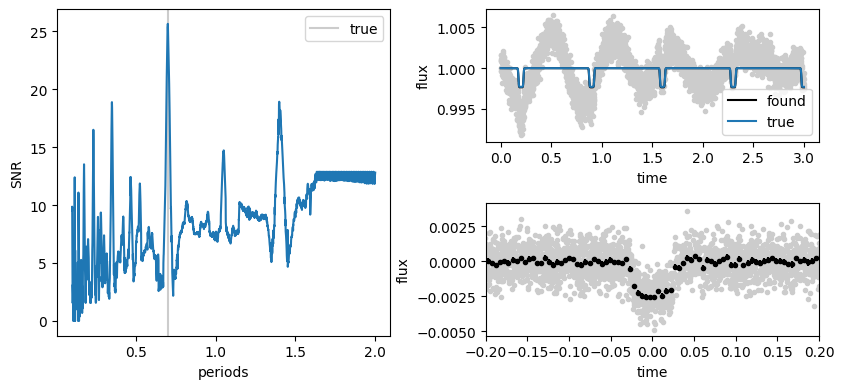

In [6]:
from nuance import utils

fig = plt.figure(figsize=(8.5, 4))

linear, found, noise = core.separate_models(time, flux, gp=gp)(t0, D, P)

ax = plt.subplot(121, xlabel="periods", ylabel="SNR")
ax.axvline(transit_prams["period"], c="0.8", ls="-", label="true")
ax.plot(periods, snr)
ax.legend()

ax = plt.subplot(222, xlabel="time", ylabel="flux")
ax.plot(time, flux, ".", c="0.8")
ax.plot(time, found + 1, c="k", label="found")
ax.plot(time, transit_model + 1, c="C0", label="true")
ax.legend()

ax = plt.subplot(224, xlabel="time", ylabel="flux", xlim=(-0.2, 0.2))
phi = utils.phase(time, t0, P)
detrended = flux - noise - linear
plt.plot(phi, detrended, ".", c=".8")
bx, by, be = utils.binn_time(phi, detrended, bins=7 / 60 / 24)
plt.errorbar(bx, by, yerr=be, fmt=".", c="k")

plt.tight_layout()

```{note}
If we want to search for another planetary candidate, we can mask the current candidate and reuse the *linear search*, only the *periodic search* needs to be reran. This is demonstrated in the [Multi-planetary search notebook](multi1.ipynb)
```